# K-Means Clustering

In [1]:
%matplotlib inline

import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Clustering using K-Means") \
    .getOrCreate()

In [3]:
# load the dataset
data = spark.read.csv("data.csv", header=True, sep=',',inferSchema="true")
data = data.dropna()

## Feature selection
Eseguo il clustering utilizzando features che tra loro hanno una una correlazione inferiore ad una certa threshold

In [4]:
categorical_columns = [ 'matchType', 'Id', 'groupId', 'matchId']
numerical_columns =[ 'assists',
                     'boosts',
                     'damageDealt',
                     'DBNOs',
                     'headshotKills',
                     'heals',
                     'killPlace',
                     'killPoints',
                     'kills',
                     'killStreaks',
                     'longestKill',
                     'matchDuration',
                     'maxPlace',
                     'numGroups',
                     'rankPoints',
                     'revives',
                     'rideDistance',
                     'roadKills',
                     'swimDistance',
                     'teamKills',
                     'vehicleDestroys',
                     'walkDistance',
                     'weaponsAcquired',
                     'winPoints',
                     'winPlacePerc']

In [5]:
# Assemblo le features numeriche
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numerical_columns, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)

In [6]:
# Creo la correlation matrix
pearsonCorr = Correlation.corr(df_vector, vector_col, 'pearson').collect()[0][0]
corr_matrix = pd.DataFrame(pearsonCorr.toArray(), numerical_columns, numerical_columns)

In [7]:
# Seleziono il triangolo superiore della correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Cerco le features con correlazione > 0.5 
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.5)]

In [8]:
to_drop

['damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'kills',
 'killStreaks',
 'longestKill',
 'numGroups',
 'rankPoints',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc']

In [9]:
# Considero gli attributi meno correlati
kmeans_feats = [col for col in numerical_columns if col not in to_drop]
kmeans_feats

['assists',
 'boosts',
 'killPoints',
 'matchDuration',
 'maxPlace',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys']

## K-Means: Ottimizzazione del miglior K
Eseguo k-means provando un range di K. Test eseguito su un sample del 1% del dataset

In [10]:
# Assemblo le features meno correlate
assemble = VectorAssembler(inputCols=kmeans_feats, outputCol='features')
ass_data = assemble.transform(data)

In [11]:
ass_data.select('features').show(5,False)

+-----------------------------------------+
|features                                 |
+-----------------------------------------+
|(11,[2,3,4],[1241.0,1306.0,28.0])        |
|(11,[3,4,6,8],[1777.0,26.0,0.0045,11.04])|
|(11,[0,3,4],[1.0,1318.0,50.0])           |
|(11,[3,4],[1436.0,31.0])                 |
|(11,[3,4],[1424.0,97.0])                 |
+-----------------------------------------+
only showing top 5 rows



In [12]:
# Normalizzo
mms = MinMaxScaler(inputCol='features',outputCol="scaled")
scaler_model = mms.fit(ass_data)
scaled_data = scaler_model.transform(ass_data)

In [13]:
scaled_data.select("scaled").show(5)

+--------------------+
|              scaled|
+--------------------+
|(11,[2,3,4],[0.57...|
|(11,[3,4,6,8],[0....|
|(11,[0,3,4],[0.04...|
|(11,[3,4],[0.6192...|
|(11,[3,4],[0.6135...|
+--------------------+
only showing top 5 rows



In [14]:
# Eseguo il clustering su un range di k: calcolo sse e silhouette
n = 15
sse = np.zeros(n+1)
silhouette = np.zeros(n+1)

for k in range(2,n+1):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('scaled').setPredictionCol('cluster')
    evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='scaled',
                                        metricName='silhouette',distanceMeasure='squaredEuclidean')
    model = kmeans.fit(scaled_data.sample(withReplacement=False, fraction=0.2, seed=42))
    predictions = model.transform(scaled_data)

    sse[k] = model.summary.trainingCost
    silhouette[k] = evaluator.evaluate(predictions)
    
    print(f"K={k}, SSE={sse[k]}, Silhouette:{silhouette[k]}")

K=2, SSE=73787.20992980906, Silhouette:0.6830865057297318
K=3, SSE=38929.96801372446, Silhouette:0.7856062606663897
K=4, SSE=28647.663041813772, Silhouette:0.8127980313679581
K=5, SSE=24537.322155575734, Silhouette:0.7297931341697048
K=6, SSE=18208.526040515175, Silhouette:0.6384803229536502
K=7, SSE=21969.373465921683, Silhouette:0.7170213952863426
K=8, SSE=15566.143018861636, Silhouette:0.6115435852363321
K=9, SSE=13676.001545181025, Silhouette:0.6227399496604689
K=10, SSE=12908.188960527854, Silhouette:0.6009615360996076
K=11, SSE=11423.180818206634, Silhouette:0.6348592916638516
K=12, SSE=10157.579509389729, Silhouette:0.6603060854890338
K=13, SSE=9111.0196474428, Silhouette:0.6398030391807433
K=14, SSE=9001.876563039947, Silhouette:0.6549722746087304
K=15, SSE=8837.17373410146, Silhouette:0.6475877152573231


Text(0.5, 0.98, 'K-Means - Silhouette')

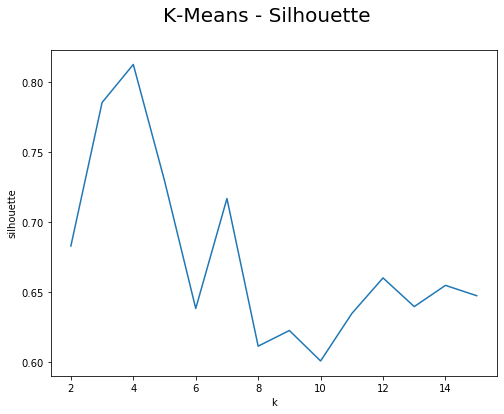

In [15]:
# silhouette
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,n+1),silhouette[2:n+1])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')
fig.suptitle('K-Means - Silhouette', fontsize=20)

Text(0.5, 0.98, 'K-Means: SSE')

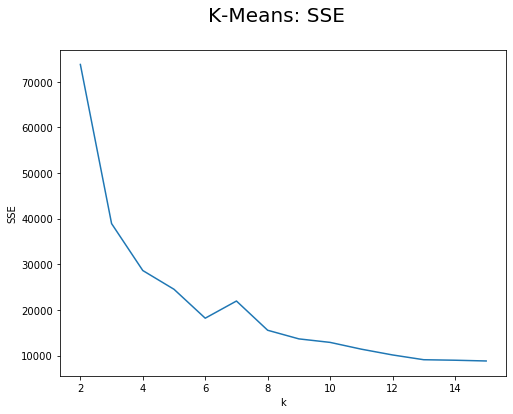

In [16]:
# sse
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,n+1),sse[2:n+1])
ax.set_xlabel('k')
ax.set_ylabel('SSE')
fig.suptitle('K-Means: SSE', fontsize=20)

## K-Means with best K=6 on Entire Dataset

In [14]:
# Eseguo il clustering col miglior k sull'intero dataset
kmeans = KMeans().setK(6).setSeed(1).setFeaturesCol('scaled').setPredictionCol('cluster')
evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='scaled',
                                    metricName='silhouette',distanceMeasure='squaredEuclidean')
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)

In [15]:
# Info sse, silhouette, cluster_sizes, centers
sse = model.summary.trainingCost
silhouette = evaluator.evaluate(predictions)
cluster_sizes = model.summary.clusterSizes
centers = model.clusterCenters()

print(f"K-Means k=6 results:\nSSE: {sse}\Silhouette: {silhouette}\nCluster sizes: {cluster_sizes}\nCentroids:\n {centers}")

K-Means k=6 results:
SSE: 97278.73850013927\Silhouette: 0.5955153498455947
Cluster sizes: [1024740, 445055, 1017521, 508442, 260983, 1190224]
Centroids:
 [array([1.15802767e-02, 3.80679859e-02, 2.54627700e-04, 8.22634815e-01,
       3.38092699e-01, 5.38433013e-03, 3.23878958e-02, 2.85004543e-04,
       1.24472451e-03, 3.67946991e-03, 3.39305580e-03]), array([2.44484594e-03, 3.28615837e-02, 2.63202596e-04, 7.03569011e-01,
       9.48972324e-01, 0.00000000e+00, 1.17615415e-02, 2.75496537e-04,
       1.36408807e-03, 1.17888051e-03, 1.02009864e-03]), array([1.40021680e-02, 3.34370286e-02, 5.92216820e-01, 6.67674744e-01,
       2.66362762e-01, 5.45735602e-03, 1.43110026e-02, 1.45014752e-04,
       1.12487927e-03, 1.56778091e-03, 1.55633152e-03]), array([1.02849847e-02, 3.20767793e-02, 5.61502236e-01, 6.80608327e-01,
       4.69439112e-01, 3.98709219e-03, 1.31882241e-02, 1.47727983e-04,
       1.11096293e-03, 1.10763207e-03, 1.12500541e-03]), array([2.92948374e-03, 3.15276544e-02, 5.59597518

In [16]:
#inverse_transfrom
X_original = centers * (scaler_model.originalMax.toArray() - scaler_model.originalMin.toArray()) + scaler_model.originalMin.toArray()

In [17]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [18]:
centers_df = pd.DataFrame(X_original, columns=kmeans_feats)
centers_df

,assists,boosts,killPoints,matchDuration,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys
0,0.255,1.256,0.553,1863.824,35.133,0.210,1318.511,0.005,4.759,0.044,0.017
1,0.054,1.084,0.571,1613.309,94.999,0.000,478.812,0.005,5.215,0.014,0.005
2,0.308,1.103,1285.110,1537.788,28.104,0.213,582.601,0.003,4.300,0.019,0.008
3,0.226,1.059,1218.460,1565.000,48.005,0.155,536.893,0.003,4.247,0.013,0.006
4,0.064,1.040,1214.327,1579.219,95.656,0.000,441.565,0.005,4.983,0.007,0.004
5,0.260,1.025,0.725,1364.006,35.002,0.186,126.126,0.002,4.218,0.023,0.003


In [19]:
center_df_scaled = pd.DataFrame(centers, columns=kmeans_feats)
center_df_scaled

,assists,boosts,killPoints,matchDuration,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys
0,0.012,0.038,0.000,0.823,0.338,0.005,0.032,0.000,0.001,0.004,0.003
1,0.002,0.033,0.000,0.704,0.949,0.000,0.012,0.000,0.001,0.001,0.001
2,0.014,0.033,0.592,0.668,0.266,0.005,0.014,0.000,0.001,0.002,0.002
3,0.010,0.032,0.562,0.681,0.469,0.004,0.013,0.000,0.001,0.001,0.001
4,0.003,0.032,0.560,0.687,0.956,0.000,0.011,0.000,0.001,0.001,0.001
5,0.012,0.031,0.000,0.585,0.337,0.005,0.003,0.000,0.001,0.002,0.001


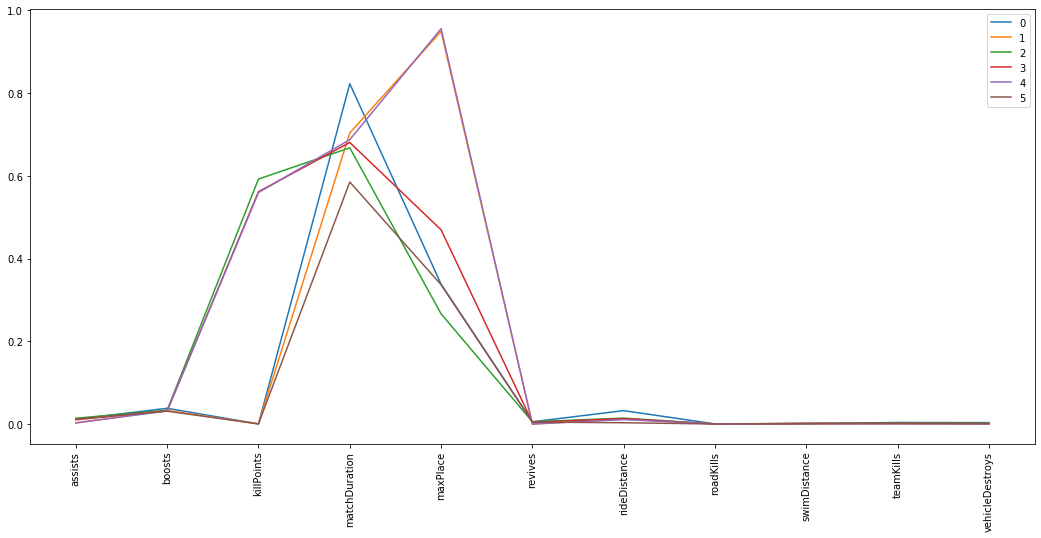

In [20]:
ax = center_df_scaled.T.plot(figsize=(18, 8))
ax.set_xticks(range(len(kmeans_feats)))
ax.set_xticklabels(kmeans_feats, rotation=90)
plt.savefig('cluster_centers.pdf', bbox_inches='tight')
plt.show()

## Plots

In [21]:
from pyspark.sql import SQLContext

sqlCtx = SQLContext(spark)

In [22]:
from pyspark.sql.functions import col
#discretizzazione matchType
toKeep = ['duo', 'solo', 'squad', 'duo-fpp', 'squad-fpp', 'solo-fpp']
predictions = predictions.filter(predictions.matchType.isin(toKeep))

predictions = predictions.withColumn("matchtype", when(col("matchtype").contains("duo"), 2)
                           .when(col("matchtype").contains("solo"), 1)
                           .otherwise(4))

In [23]:
#discretizzazione winPlacePerc
predictions = predictions.withColumn('winPlaceClass', when(col("winPlacePerc") == 0, 6)
                                .when(col("winPlacePerc") == 1,  1)
                                .when( (col("winPlacePerc") > 0) & (col("winPlacePerc") <= 0.25 ), 5)
                                .when( (col("winPlacePerc") > 0.25) & (col("winPlacePerc") <= 0.5 ), 4)
                                .when( (col("winPlacePerc") > 0.5) & (col("winPlacePerc") <= 0.75 ), 3)
                                .when( (col("winPlacePerc") > 0.75) & (col("winPlacePerc") < 1 ), 2)
               )

In [24]:
predictions.createOrReplaceTempView("pubg")

In [25]:
#analizziamo le distribuzioni di winPlacePerc e matchType nei cluster
cols = kmeans_feats + ['cluster', 'winPlacePerc', 'winPlaceClass', 'matchType']
sample_df = predictions.select(cols).sample(withReplacement=False, fraction=0.001, seed=42).toPandas()
sample_df.head()

,assists,boosts,killPoints,matchDuration,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,cluster,winPlacePerc,winPlaceClass,matchType
0,0,0,0,1808,16,0,0.000,0,0.000,0,0,0,0.000,6,1
1,1,2,999,1884,22,0,0.000,0,0.000,0,0,2,0.143,5,2
2,0,0,0,1896,48,0,0.000,0,0.000,0,0,0,0.489,4,2
3,0,0,0,1942,46,1,0.000,0,0.000,0,0,0,0.267,4,2
4,0,0,1167,1358,29,0,0.000,0,0.000,0,0,2,0.250,5,4


In [26]:
# Normalizzo il dataframe sample
from sklearn.preprocessing import MinMaxScaler

sample_df[kmeans_feats] = MinMaxScaler().fit_transform(sample_df.loc[:, ~sample_df.columns.isin(['cluster', 'matchType','winPlaceClass', 'winPlacePerc'])])
sample_df.head()

,assists,boosts,killPoints,matchDuration,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,cluster,winPlacePerc,winPlaceClass,matchType
0,0.000,0.000,0.000,0.671,0.034,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,6,1
1,0.167,0.143,0.471,0.732,0.103,0.000,0.000,0.000,0.000,0.000,0.000,2,0.143,5,2
2,0.000,0.000,0.000,0.742,0.402,0.000,0.000,0.000,0.000,0.000,0.000,0,0.489,4,2
3,0.000,0.000,0.000,0.778,0.379,0.250,0.000,0.000,0.000,0.000,0.000,0,0.267,4,2
4,0.000,0.000,0.550,0.310,0.184,0.000,0.000,0.000,0.000,0.000,0.000,2,0.250,5,4


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


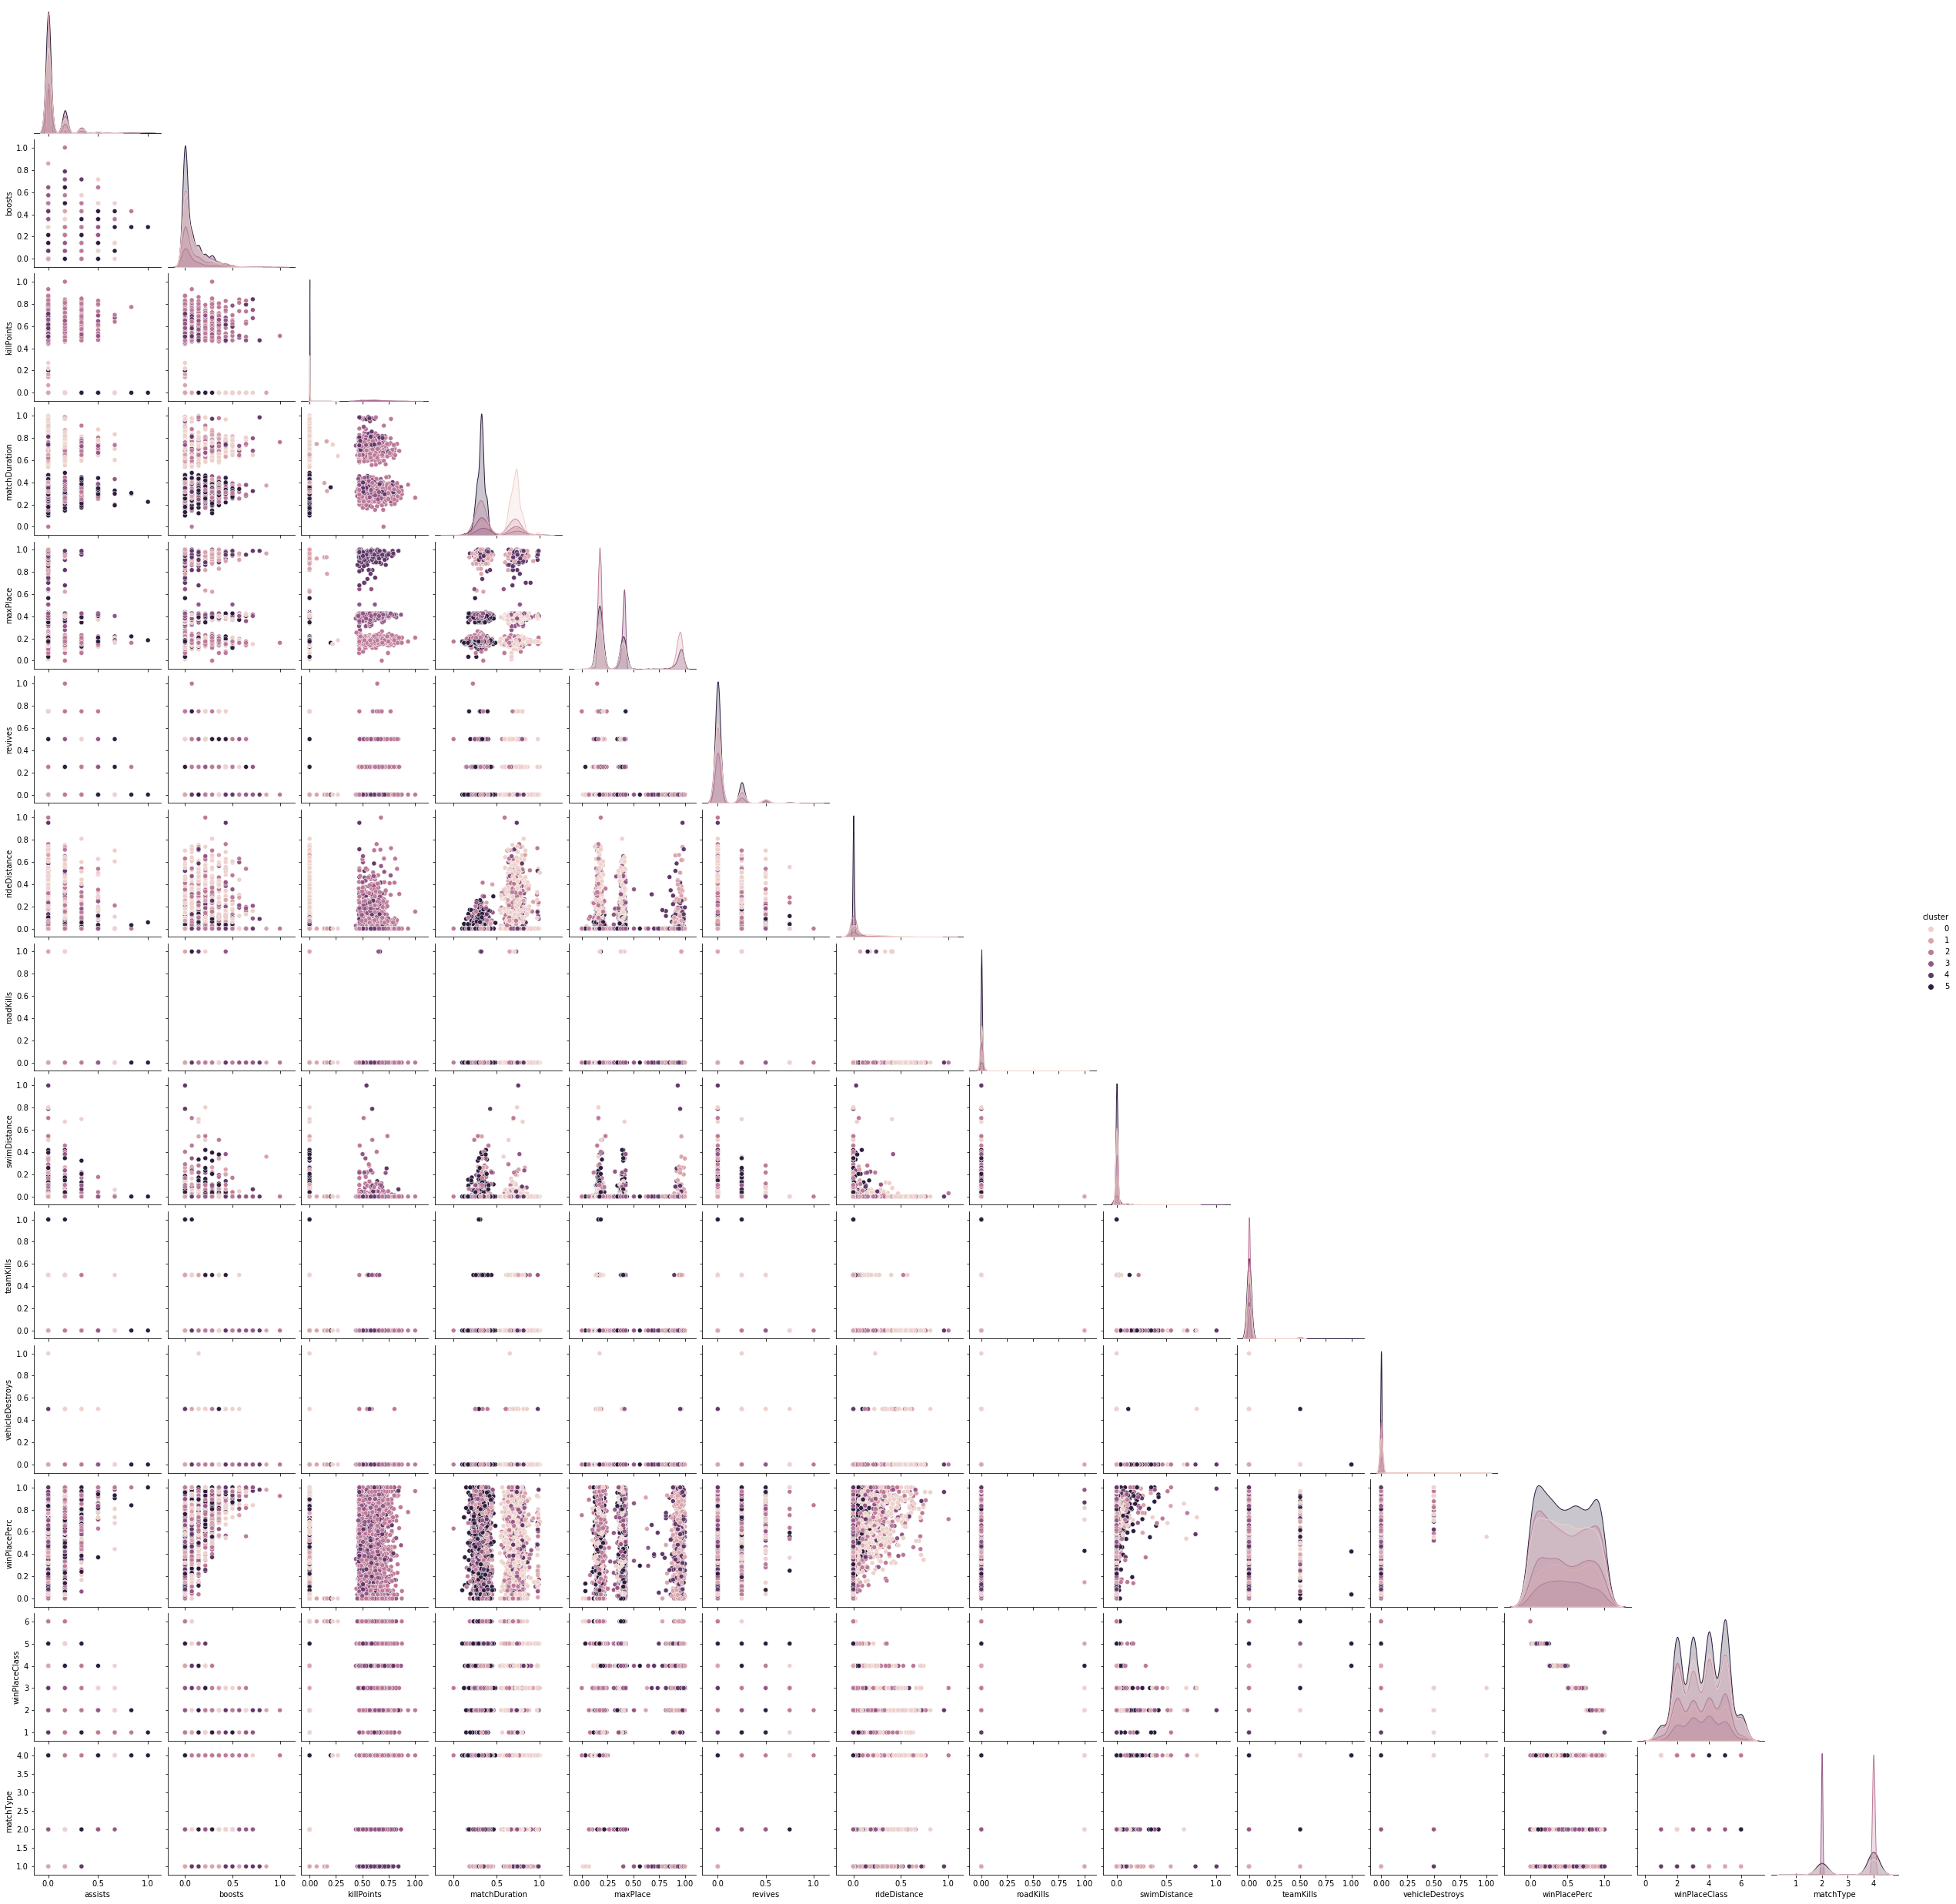

In [27]:
sns.pairplot(sample_df,hue = "cluster", corner=True)

In [28]:
winPlaceClass = sqlCtx.sql("""SELECT winPlaceClass, COUNT(*) as count FROM pubg GROUP BY winPlaceClass""")
winPlaceClass.show()

+-------------+-------+
|winPlaceClass|  count|
+-------------+-------+
|            1| 124921|
|            6| 217551|
|            3| 952096|
|            5|1126345|
|            4|1058114|
|            2| 932671|
+-------------+-------+



In [29]:
total = sqlCtx.sql("""SELECT COUNT(*) as total FROM pubg""")
total.show()

+-------+
|  total|
+-------+
|4411698|
+-------+



In [30]:
winPlaceClassDF = winPlaceClass.toPandas().set_index('winPlaceClass').sort_index() / total.toPandas().iloc[0,0]

In [31]:
cluster_matchType = sqlCtx.sql("""SELECT cluster, matchtype, COUNT(*) as count FROM pubg GROUP BY cluster, matchtype""")
cluster_count = sqlCtx.sql("""SELECT cluster, COUNT(*) as count FROM pubg GROUP BY cluster""")
cluster_matchType.show()

+-------+---------+------+
|cluster|matchtype| count|
+-------+---------+------+
|      3|        1|  3200|
|      2|        2|  6074|
|      1|        1|445055|
|      5|        4|752724|
|      2|        1|   434|
|      2|        4|998868|
|      0|        1|  7103|
|      3|        2|504831|
|      5|        2|422849|
|      5|        1|  1929|
|      0|        2|376528|
|      3|        4|    11|
|      4|        1|260983|
|      0|        4|631109|
+-------+---------+------+



In [32]:
cluster_matchTypeDF = cluster_matchType.toPandas().set_index(['cluster','matchtype'])
cluster_countDF = cluster_count.toPandas().set_index('cluster')

In [33]:
cluster_matchTypePerc = (cluster_matchTypeDF/cluster_countDF).reset_index()

In [34]:
matchtype_pivot_df = cluster_matchTypePerc.pivot(index='cluster', columns='matchtype', values='count')
matchtype_pivot_df

matchtype,1,2,4
cluster,,,
0,0.007,0.371,0.622
1,1.000,NaN,NaN
2,0.000,0.006,0.994
3,0.006,0.994,0.000
4,1.000,NaN,NaN
5,0.002,0.359,0.639


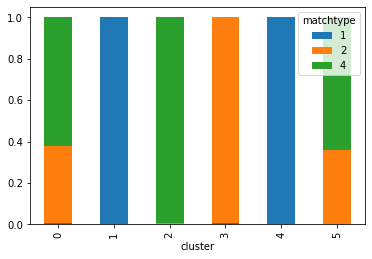

In [35]:
matchtype_pivot_df.plot.bar(stacked=True)
plt.savefig('matchtype_cluster.pdf', bbox_inches='tight')
plt.show()

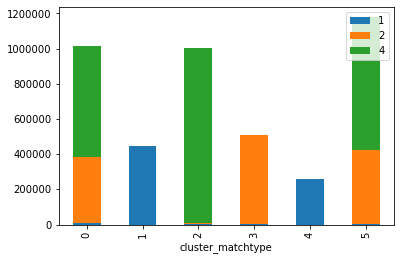

In [36]:
cross_tab = predictions.crosstab('cluster', 'matchtype').toPandas().sort_values(by=["cluster_matchtype"]).set_index('cluster_matchtype')
cross_tab.plot.bar(stacked=True)

In [37]:
cluster_winPlaceClass = sqlCtx.sql("""SELECT cluster, winPlaceClass, COUNT(*) as count FROM pubg GROUP BY cluster, winPlaceClass""")
cluster_winPlaceClass.show()

+-------+-------------+------+
|cluster|winPlaceClass| count|
+-------+-------------+------+
|      3|            1| 10657|
|      2|            2|197820|
|      2|            3|206247|
|      1|            2|104971|
|      0|            5|261038|
|      5|            6| 63789|
|      1|            1|  4677|
|      1|            3|105234|
|      3|            5|125520|
|      2|            5|268538|
|      1|            4|111223|
|      5|            4|282313|
|      3|            3|115377|
|      4|            3| 62056|
|      2|            1| 37230|
|      2|            4|234868|
|      4|            6|  4929|
|      3|            6| 16084|
|      0|            1| 32364|
|      3|            2|114346|
+-------+-------------+------+
only showing top 20 rows



In [38]:
cluster_winPlaceClassDF = cluster_winPlaceClass.toPandas().set_index(['cluster','winPlaceClass'])

In [39]:
cluster_winPlaceClassPerc = (cluster_winPlaceClassDF/cluster_countDF).reset_index()

In [40]:
winPlaceClass_pivot_df = cluster_winPlaceClassPerc.pivot(index='cluster', columns='winPlaceClass', values='count')
winPlaceClass_pivot_df

winPlaceClass,1,2,3,4,5,6
cluster,,,,,,
0,0.032,0.206,0.209,0.235,0.257,0.061
1,0.011,0.236,0.236,0.250,0.245,0.023
2,0.037,0.197,0.205,0.234,0.267,0.060
3,0.021,0.225,0.227,0.248,0.247,0.032
4,0.011,0.238,0.238,0.250,0.245,0.019
5,0.032,0.207,0.214,0.240,0.253,0.054


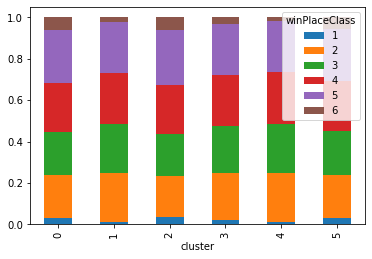

In [41]:
winPlaceClass_pivot_df.plot.bar(stacked=True)
plt.savefig('winPlaceClass_cluster.pdf', bbox_inches='tight')
plt.show()

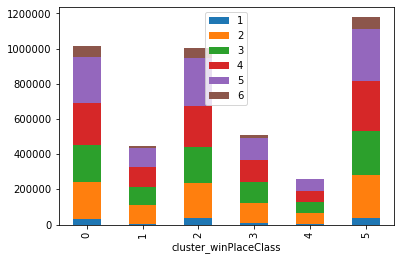

In [42]:
cross_tab = predictions.crosstab('cluster', 'winPlaceClass').toPandas().sort_values(by=["cluster_winPlaceClass"]).set_index('cluster_winPlaceClass')
cross_tab.plot.bar(stacked=True)

<Figure size 432x288 with 0 Axes>

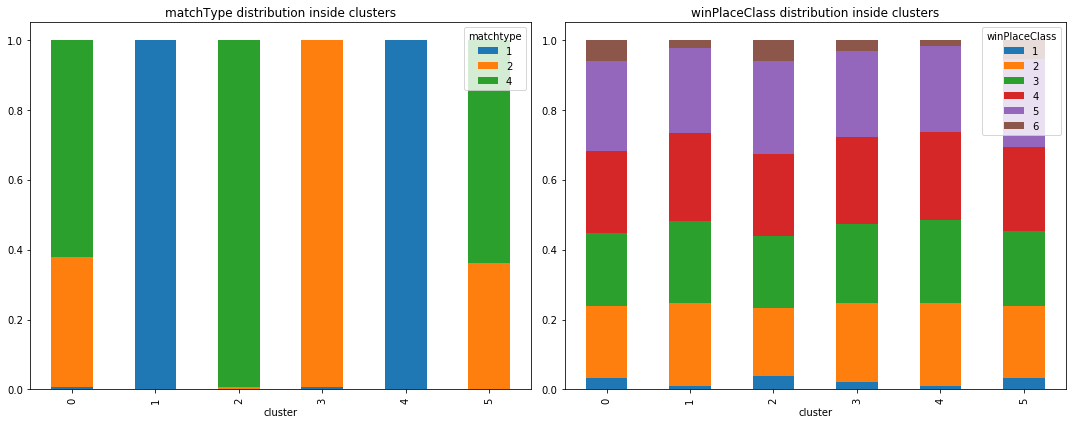

In [43]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

matchtype_pivot_df.plot.bar(stacked=True, ax=axes[0], title="matchType distribution inside clusters")
winPlaceClass_pivot_df.plot.bar(stacked=True, ax=axes[1], title='winPlaceClass distribution inside clusters')

fig.tight_layout()
fig.savefig('cluster_matchtype_class.pdf', bbox_inches='tight')
plt.show()

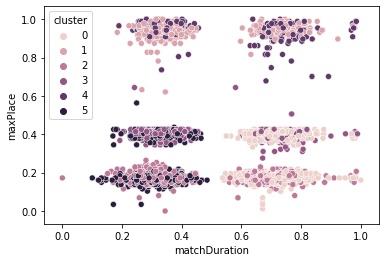

In [44]:
sns.scatterplot(data=sample_df, x="matchDuration", y="maxPlace", hue="cluster")
fig.savefig('maxPlace_matchDuration.pdf', bbox_inches='tight')
plt.show()

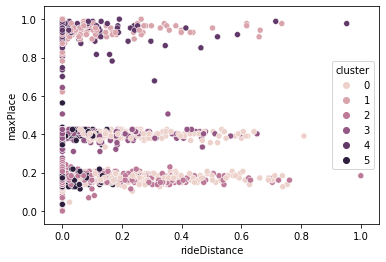

In [45]:
sns.scatterplot(data=sample_df, x="rideDistance", y="maxPlace", hue="cluster")

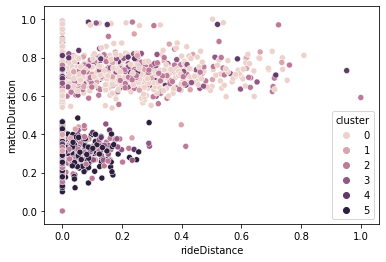

In [46]:
sns.scatterplot(data=sample_df, x="rideDistance", y="matchDuration", hue="cluster")

In [56]:
def plot3d(df,x,y,z):
    threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
    threedee.scatter(df[x], df[y], df[z], c=df.cluster)
    threedee.set_xlabel(x)
    threedee.set_ylabel(y)
    threedee.set_zlabel(z)
    plt.show()

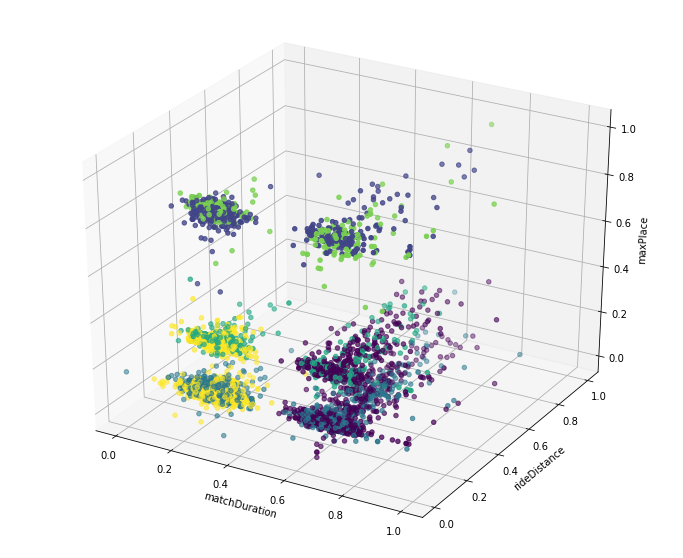

In [57]:
plot3d(sample_df,'matchDuration','rideDistance','maxPlace')

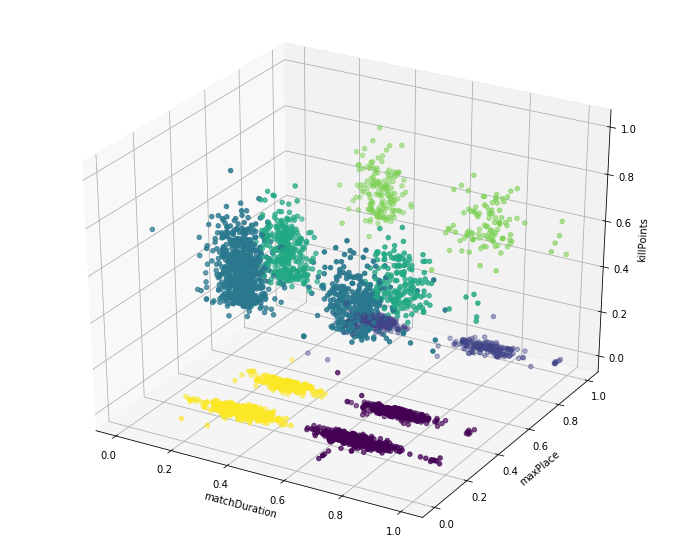

In [58]:
plot3d(sample_df,'matchDuration','maxPlace','killPoints')

In [59]:
cl = sample_df['cluster']
sample_df = sample_df.drop(inplace=False, columns=['cluster', 'matchType','winPlaceClass', 'winPlacePerc'])

In [60]:
from sklearn.decomposition import PCA
pca = PCA(10,random_state=42)
pca.fit(sample_df)
pca_proj = pca.transform(sample_df)
df_pca = pd.DataFrame(pca_proj[:,:3], columns= ['pca1', 'pca2', 'pca3'])
df_pca

,pca1,pca2,pca3
0,-0.176,-0.359,0.139
1,0.262,-0.193,0.268
2,-0.269,-0.003,0.194
3,-0.263,-0.045,0.243
4,0.364,-0.095,-0.145
...,...,...,...
4552,-0.390,0.538,0.114
4553,0.295,-0.137,-0.104
4554,0.149,0.700,0.310
4555,-0.163,-0.236,-0.223


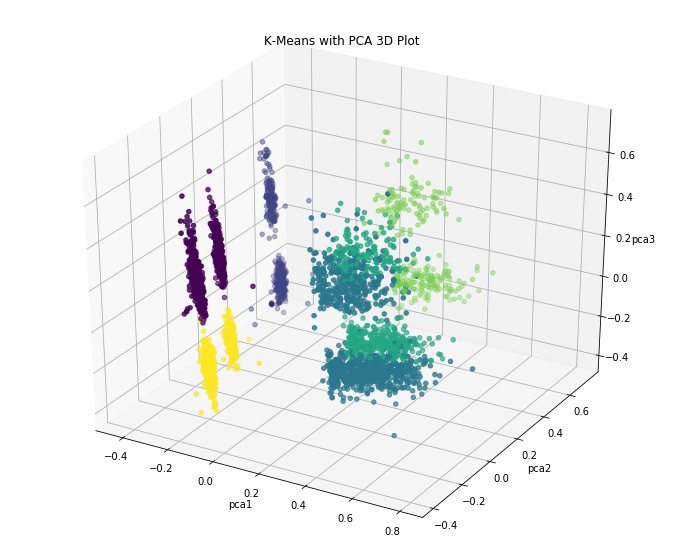

In [61]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')

x = df_pca['pca1']
y = df_pca['pca2']
z = df_pca['pca3']
c = cl

ax.set_xlabel("pca1")
ax.set_ylabel("pca2")
ax.set_zlabel("pca3")

scatter = ax.scatter(x, y, z, c=c, cmap='viridis')
ax.set_title('K-Means with PCA 3D Plot')

plt.show()